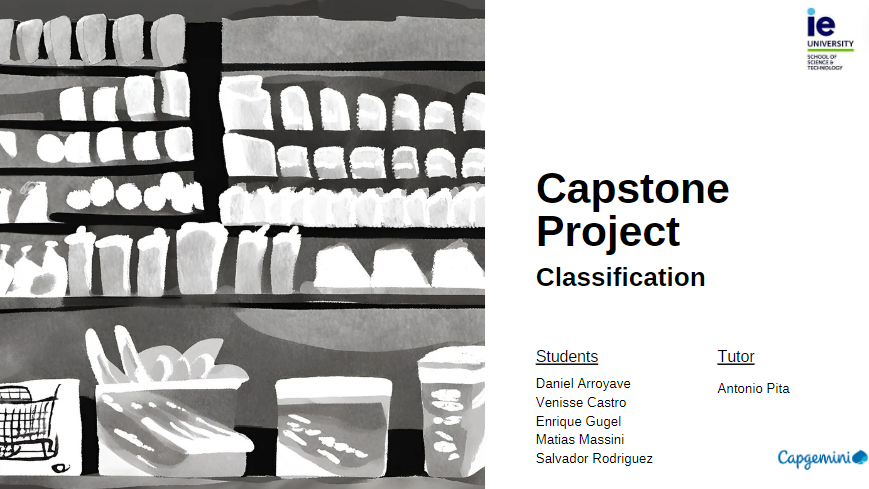

The purpose of this notebook is to create a cluster identification model so when the customer is perfomring purhcases we can identify to which cluster he belongs.

# **1.   Libraries to be imported**



In [ ]:
import os
from google.colab import drive
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import KFold

from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib


# **2.   Import Data**

We will create a Dataframe with each of the excel files providede by Capgemini



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Update the route to access the data:
#route = '/content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/df_final_version.csv'
#destination = '/content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/Cluster_models/'

#in case you accessing the google shared drive use this and discard the previous by adding a # before and deleting the # in the next line:
route = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/df_final_version.csv'
destination = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/Cluster_models/'

In [ ]:
# Path to the CSV file
file_path = route

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

df.head(5)


,id_orden,id_producto,incluido_orden_carrito,reordenado,nombre_producto,id_pasillo,id_departamento,pasillo,departamento
0,1,49302,1,1,EL YOGUR DE BULGARIA,120.0,16.0,YOGUR,HUEVOS Y LÁCTEOS
1,1,11109,2,1,4% ORGÁNICO QUESO GRASA DE LECHE LECHE ENTERA ...,108.0,16.0,OTROS QUESOS CREMAS,HUEVOS Y LÁCTEOS
2,1,10246,3,0,CORAZONES DE APIO ORGÁNICOS,83.0,4.0,VEGETALES FRESCOS,FRUTAS Y VERDURAS
3,1,49683,4,0,KIRBY PEPINO,83.0,4.0,VEGETALES FRESCOS,FRUTAS Y VERDURAS
4,1,43633,5,1,LAS SARDINAS LIGERAMENTE AHUMADO EN ACEITE DE ...,95.0,15.0,MARISCOS CARNE ENLATADA,PRODUCTOS ENLATADOS


In [ ]:
route = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/df_final_version.csv'
destination = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged'

In [ ]:
# Path to the CSV file
file_path = route

# Read the CSV file into a DataFrame
df2 = pd.read_csv(file_path)


In [ ]:
clusters2 = df2[['id_orden', 'cluster2']]
clusters2 =  clusters2.drop_duplicates(subset=['id_orden'])
clusters2 =  clusters2.set_index('id_orden')
clusters2.columns =['cluster']

In [ ]:
clusters2

,cluster
id_orden,
1,1
36,0
38,0
96,1
98,0
...,...
3421049,1
3421056,2
3421058,0


# **Classification**

### Function to prepare sequence data

In [ ]:
# Function to prepare sequence-based data for clustering
def prepare_sequence_based_data(df, max_sequence_length):
    sequences = []

    for order_id, order_data in df.groupby('id_orden'):
        sorted_order_data = order_data.sort_values('incluido_orden_carrito')
        sequence = list(sorted_order_data['id_producto'].values)

        # Pad sequences with zeros if they are shorter than max_sequence_length
        if len(sequence) < max_sequence_length:
            sequence.extend([0] * (max_sequence_length - len(sequence)))

        # Truncate sequences if they are longer than max_sequence_length
        sequence = sequence[:max_sequence_length]

        sequences.append([order_id] + sequence)

    sequence_columns = ['id_orden'] + [f'product_{i+1}' for i in range(max_sequence_length)]
    sequence_df = pd.DataFrame(sequences, columns=sequence_columns)
    return sequence_df

# Determine the maximum sequence length to consider (e.g., 10)
max_sequence_length = 9

# Prepare the sequence-based data using the entire dataset
sequence_based_data = prepare_sequence_based_data(df, max_sequence_length)

# Display the prepared sequence data
sequence_based_data.head()

,id_orden,product_1,product_2,product_3,product_4,product_5,product_6,product_7,product_8,product_9
0,1,49302,11109,10246,49683,43633,13176,22035,0,0
1,36,39612,19660,49235,43086,46620,34497,48679,46979,0
2,38,11913,18159,4461,21616,23622,32433,28842,42625,39693
3,96,20574,30391,40706,25610,27966,24489,39275,0,0
4,98,8859,19731,43654,13176,4357,37664,34065,35951,43560


In [ ]:
# Realizamos la unión de los dos DataFrames utilizando id_orden como clave
sequence_based_data = sequence_based_data.merge(clusters2, left_on='id_orden', right_index=True)


In [ ]:
sequence_based_data['cluster'].value_counts()

cluster
3    34004
0    28627
2    23786
4    22953
1    21783
Name: count, dtype: int64

In [ ]:
# Function to train and evaluate the model
def train_and_evaluate(sequence_based_data):
    X = sequence_based_data.drop(columns=['id_orden', 'cluster'])
    y = sequence_based_data['cluster']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # save modele
    model_path1 = '/content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/Cluster_models/random_forest_model2.joblib'
    model_path2 = '/content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/Cluster_models/feature_names2.joblib'
    joblib.dump(clf, model_path1)
    joblib.dump(X.columns, model_path2)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [ ]:
# Train and evaluate the model
accuracy_label = train_and_evaluate(sequence_based_data)

accuracy_label

0.7674477710567783